<a href="https://colab.research.google.com/github/liuxx479/cosmo_dep_feedback/blob/master/GP_pca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import numpy as np
from scipy import *
from pylab import *
import os
import pickle
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
import time

# import jax.numpy as jnp
# from jax import jit, grad, random, vmap
# from jax.config import config
# from jax.experimental import optimizers
# from jax.experimental import stax
# from jax.experimental.stax import (Dropout, AvgPool, BatchNorm, Conv, Dense, FanInSum,
#                                    FanOut, Flatten, GeneralConv, Identity,
#                                    MaxPool, Relu, LogSoftmax, LeakyRelu)
# from jax.experimental.stax import (Tanh, Relu, Exp, LogSoftmax, Softmax, Softplus, Sigmoid, 
#                                    Elu, LeakyRelu, Selu, Gelu)
# import tensorflow as tf
# import tensorflow_datasets as tfds

%matplotlib inline

In [9]:
############ colab specific, for mounting google drive
from google.colab import drive
drive.mount('/content/drive')

root = '/content/drive/My Drive'
home = os.path.join(root,'cosmo_dep_feedback/')
### home = '/global/homes/j/jialiu/cosmo_dep_feedback/'

###### the simulation we operate with
isim = 'IllustrisTNG'

### fixed parameters for the simulations: 
Omega_b = 0.049
h = 0.6711
ns = 0.9624
w = -1
mnu = 0.0 #eV
Omega_k = 0.0

#### Omega_m sigma_8 A1 A2 A3 A4
lhc_params = np.loadtxt(home+'latin_hypercube_params_%s.txt'%(isim))
lhc_params = concatenate([lhc_params[:,:2], log10(lhc_params[:,2:])],axis=1)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
############ load the data from file
z=0
kcut=39
k=np.load(home+'Pk/IllustrisTNG_k_m_z=0.00.npy')[:kcut]

Pk_arr = np.load(home+'Pk/%s_Pk_m_z=0.00.npy'%(isim))[:,:kcut]
Pk_DM_arr = np.load(home+'Pk/%s_DM_Pk_m_z=0.00.npy'%(isim))[:,:kcut]

r_arr0 = Pk_arr/Pk_DM_arr
print (r_arr0.shape)

(1000, 39)


In [11]:
######### split the dataset to 3 sets: training, validation, test
ncomp=3 ### pca components
num_params = 6
data_size = 1000
batch_size = 64 ### number of maps per batch
valid_size = 128 
test_size = 128
train_size = data_size - valid_size - test_size
shuffle_size = 1000

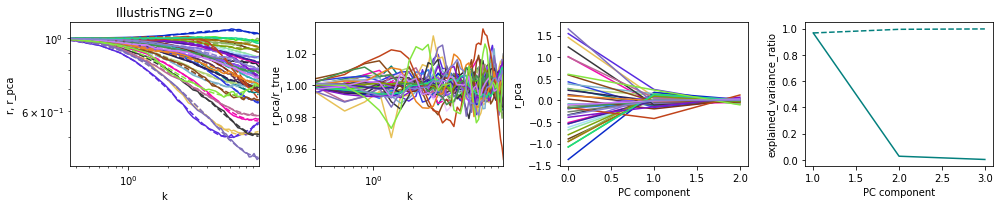

In [48]:
### try a few things (1) PCA; (2) weight decay; (3) dropouts
from sklearn.decomposition import PCA

seed(9)
icolor=rand(3)

pca = PCA(n_components=ncomp)
pca.fit(r_arr0[:train_size])
x=arange(1,ncomp+1)
evr=pca.explained_variance_ratio_

rpca_arr=pca.transform(r_arr0)
r_inverse = pca.inverse_transform(rpca_arr)

####### plot out everything
f, ax=subplots(1,4, figsize=(14,3))
seed(9)

ax[3].plot(x, evr, '-', color=icolor,label='%i components'%(ncomp))
ax[3].plot(x, np.cumsum(evr), '--', color=icolor)
ax[3].set_xlabel('PC component')
ax[3].set_ylabel('explained_variance_ratio')
ax[2].set_xlabel('PC component')
ax[2].set_ylabel('r_pca')

for i in arange(train_size, train_size+40):
  icolor=rand(3)
  # print (i)
  ax[0].plot(k, r_arr0[i], color=icolor)
  ax[0].plot(k, r_inverse[i], '--', color=icolor)
  ax[1].plot(k, r_inverse[i]/r_arr0[i], color=icolor)
  ax[2].plot(rpca_arr[i], color=icolor)
ax[0].set_xlim(k[0], k[-1])
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('k')
ax[0].set_ylabel('r, r_pca')
ax[0].set_title('%s z=%i'%(isim,z))

ax[1].set_xlim(k[0], k[-1])
ax[1].set_xscale('log')
ax[1].set_xlabel('k')
ax[1].set_ylabel('r_pca/r_true')
plt.tight_layout()
show()

In [51]:
lhc_train = lhc_params[:train_size]
r_train = r_arr0[:train_size]
rpca_train = rpca_arr[:train_size]

lhc_valid = lhc_params[train_size:train_size+valid_size]
r_valid = r_arr0[train_size:train_size+valid_size]
rpca_valid = rpca_arr[train_size:train_size+valid_size]

lhc_test= lhc_params[-test_size:]
r_test = r_arr0[-test_size:]
rpca_test = rpca_arr[-test_size:]

print (lhc_params.shape, r_arr0.shape, rpca_arr.shape)
print (lhc_train.shape, r_train.shape, rpca_train.shape)
print (lhc_valid.shape, r_valid.shape, rpca_valid.shape)
print (lhc_test.shape, r_test.shape, rpca_test.shape)

(1000, 6) (1000, 39) (1000, 3)
(744, 6) (744, 39) (744, 3)
(128, 6) (128, 39) (128, 3)
(128, 6) (128, 39) (128, 3)


In [ ]:
#### next, build a GP on individual PCA components
kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
noise_std = 0.05

nfull = noise_std
GP_full = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, alpha=nfull**2)

n0=noise_std
n1=noise_std/10
n2=noise_std/10
GP0 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, alpha=n0**2)
GP1 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, alpha=n1**2)
GP2 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, alpha=n2**2)

GP_full.fit(lhc_train, rpca_train)
GP0.fit(lhc_train, rpca_train[:,0])
GP1.fit(lhc_train, rpca_train[:,1])
GP2.fit(lhc_train, rpca_train[:,2])

In [ ]:
# ilhc = lhc_valid
# r_true = r_valid
# rpca_true = rpca_valid


ilhc = lhc_train
r_true = r_train
rpca_true = rpca_train

rpca_pred_full = GP_full.predict(ilhc)
r_pred_full=pca.inverse_transform(rpca_pred_full)
r_pred_full.shape

rpca_pred_joint = array([iGP.predict(ilhc) for iGP in [GP0, GP1, GP2]]).T
rpca_pred_joint.shape
r_pred_joint = pca.inverse_transform(rpca_pred_joint)
r_pred_joint.shape

seed(9)
f, ax=subplots(1,2, figsize=(10,4))

for i in range(10):
  icolor=rand(3)  
  ir_true=r_true[i]
  ir_pred=r_pred_full[i]  
  ir_pred_joint=r_pred_joint[i]
  ax[0].plot(k, ir_true, color=icolor)
  ax[0].plot(k, ir_pred, '--', color=icolor)
  ax[0].plot(k, ir_pred_joint, ':', color=icolor)
  ax[1].plot(k, ir_pred/ir_true-1, '--', color=icolor)
  ax[1].plot(k, ir_pred_joint/ir_true-1, ':', color=icolor)
ax[0].set_xscale('log')
ax[0].set_xlabel('k')
ax[0].set_ylabel('r')
ax[0].set_title('%s z=%i noise=%.3f'%(isim,z, noise_std))
ax[1].plot(k, zeros(len(k)),'k--')

# ax[1].set_ylim(-0.1, 0.1)
ax[1].set_xscale('log')
ax[1].set_xlabel('k')
ax[1].set_ylabel('r_pred/r_true-1')
ax[1].set_title('- true; -- pred; : joint')
plt.tight_layout()
show()

In [ ]:
seed(9)
narr=arange(ncomp)
f, ax=subplots(1,2, figsize=(10,4))
for i in range(10):
  icolor=rand(3)  
  ir_true=rpca_true[i]
  ir_pred=rpca_pred_full[i]  
  ir_pred_joint=rpca_pred_joint[i]
  ax[0].plot(ir_true, color=icolor)
  ax[0].plot(ir_pred, '--', color=icolor)
  ax[0].plot(ir_pred_joint, ':', color=icolor)
  ax[1].plot(ir_pred/ir_true-1, '--', color=icolor)
  ax[1].plot(ir_pred_joint/ir_true-1, ':', color=icolor)
# ax[0].set_xscale('log')

ax[0].set_ylim(-0.5, 0.5)
ax[0].set_xlabel('ncomp')
ax[0].set_ylabel('rpca')
ax[0].set_title('%s z=%i noise=%.3f'%(isim,z, noise_std))

ax[1].plot(narr, zeros(ncomp),'k--')
# ax[1].set_ylim(-1, 1)
# ax[1].set_xscale('log')
ax[1].set_xlabel('ncomp')
ax[1].set_ylabel('r_pred/r_true-1')
ax[1].set_title('- true; -- pred; : joint')
plt.tight_layout()
show()
